In [1]:
import pandas as pd
import numpy as np

from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder
import sys
sys.path.append("/home/leon/projects/gaussian_process/")
from sklearn.model_selection import cross_val_score


In [2]:
from gecs100.gec import GEC
from gecs100.utils.gaussian_process_visualisation import visualise_1D_gaussian_process, visualise_2D_gaussian_process

gec = GEC()

In [3]:
path = "/home/leon/learning/gaussian-processes/bank/bank-full.csv"
data = pd.read_csv(path, sep=";")
one_hot_encode = ["job", "marital", "education", "contact", "poutcome", "month"]
binary = ["default", "housing", "loan", "y"]

In [4]:
enc = OneHotEncoder()
def yesNoBinary(column):
    return(pd.DataFrame([1 if value == "yes" else 0 for value in column], columns = [column.name]))
one_hot = pd.DataFrame(enc.fit_transform(data[one_hot_encode]).toarray(), columns=enc.get_feature_names_out(one_hot_encode))
data2 = pd.concat([one_hot] + [ yesNoBinary(data[col]) if col in binary else data[col] for col in data.columns ], 1).drop(one_hot_encode, 1)
X, y = data2.values[:,:-1], data2.values[:,-1]

/tmp/ipykernel_51050/915973979.py:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data2 = pd.concat([one_hot] + [ yesNoBinary(data[col]) if col in binary else data[col] for col in data.columns ], 1).drop(one_hot_encode, 1)
/tmp/ipykernel_51050/915973979.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data2 = pd.concat([one_hot] + [ yesNoBinary(data[col]) if col in binary else data[col] for col in data.columns ], 1).drop(one_hot_encode, 1)


In [5]:
gec.fit(X, y, 1)

[LightGBM] [Warning] lambda_l1 is set=0.2013076331082478, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2013076331082478
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] lambda_l1 is set=0.2013076331082478, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2013076331082478
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] lambd

GEC(boosting='gbdt', feature_fraction=1.0, lambda_l1=0.2013076331082478,
    learning_rate=0.042320591021281925, min_data_in_leaf=18, num_leaves=168)

In [6]:
np.mean(gec.predict(X))

0.09740992236402646

In [7]:
gec.gp_datas["gbdt"][0].shape

(1, 5)

In [8]:
print(gec.best_params_)
knn_bayes = LGBMClassifier(**gec.best_params_)
score_bayes = np.mean(cross_val_score(knn_bayes, X, y, cv=5))
score_bayes

{'boosting': 'gbdt', 'lambda_l1': 0.2013076331082478, 'num_leaves': 168, 'min_data_in_leaf': 18, 'feature_fraction': 1.0, 'learning_rate': 0.042320591021281925}
[LightGBM] [Warning] lambda_l1 is set=0.2013076331082478, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2013076331082478
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] lambda_l1 is set=0.2013076331082478, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2013076331082478
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_

0.6426040391011483

In [9]:
from sklearn.model_selection import RandomizedSearchCV
classifier = LGBMClassifier()
hyperparams = dict(gec.hyperparameters[0] + gec.hyperparameters[1])
gs = RandomizedSearchCV(classifier, hyperparams, n_iter=1)
gs.fit(X, y)

[LightGBM] [Warning] lambda_l1 is set=0.36577047334764196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36577047334764196
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] lambda_l1 is set=0.36577047334764196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36577047334764196
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignor

RandomizedSearchCV(estimator=LGBMClassifier(), n_iter=1,
                   param_distributions={'boosting': ['gbdt'],
                                        'feature_fraction': [0.1, 0.2,
                                                             0.30000000000000004,
                                                             0.4, 0.5, 0.6,
                                                             0.7000000000000001,
                                                             0.8, 0.9, 1.0],
                                        'lambda_l1': [0.0, 0.005345903794965073,
                                                      0.01094901577639535,
                                                      0.016821711036271933,
                                                      0.022976960071036508,
                                                      0.029428357428366223,
                                                      0.03619015173223435,
                                                      0.043277277152570855,...
                                                          0.13814807178448418,
                                                          0.1554977602463686,
                                                          0.17502635490532265,
                                                          0.19700749941933254,
                                                          0.22174920370393889,
                                                          0.2495981599089605,
                                                          0.28094460042849034,
                                                          0.31622776601683794],
                                        'min_data_in_leaf': [2, 4, 6, 8, 10, 12,
                                                             14, 16, 18, 20, 22,
                                                             24, 26, 28, 30, 32,
                                                             34, 36, 38, 40, 42,
                                                             44, 46, 48],
                                        'num_leaves': [10, 11, 12, 13, 14, 15,
                                                       16, 17, 18, 19, 20, 21,
                                                       22, 23, 24, 25, 26, 27,
                                                       28, 29, 30, 31, 32, 33,
                                                       34, 35, 36, 37, 38, 39, ...]})

In [10]:

knn_bayes = LGBMClassifier(**gec.best_params_)
score_bayes = np.mean(cross_val_score(knn_bayes, X, y, cv=5))

knn_gs = LGBMClassifier(**gs.best_params_)
score_gs = np.mean(cross_val_score(knn_gs, X, y, cv=5))
#score_gs= "None"
knn_default = LGBMClassifier()
score_default = np.mean(cross_val_score(knn_default, X, y, cv=5))
print(f"bayesian: {score_bayes}, random search: {score_gs}, default: {score_default}")


[LightGBM] [Warning] lambda_l1 is set=0.2013076331082478, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2013076331082478
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] lambda_l1 is set=0.2013076331082478, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2013076331082478
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] lambd

In [11]:
gs.best_params_

{'num_leaves': 137,
 'min_data_in_leaf': 2,
 'learning_rate': 0.22174920370393889,
 'lambda_l1': 0.36577047334764196,
 'feature_fraction': 0.30000000000000004,
 'boosting': 'gbdt'}

In [12]:
gec.best_params_

{'boosting': 'gbdt',
 'lambda_l1': 0.2013076331082478,
 'num_leaves': 168,
 'min_data_in_leaf': 18,
 'feature_fraction': 1.0,
 'learning_rate': 0.042320591021281925}

In [13]:
np.array(dir(gs))

array(['__abstractmethods__', '__class__', '__delattr__', '__dict__',
       '__dir__', '__doc__', '__eq__', '__format__', '__ge__',
       '__getattribute__', '__getstate__', '__gt__', '__hash__',
       '__init__', '__init_subclass__', '__le__', '__lt__', '__module__',
       '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__',
       '__setattr__', '__setstate__', '__sizeof__', '__str__',
       '__subclasshook__', '__weakref__', '_abc_impl',
       '_check_feature_names', '_check_n_features',
       '_check_refit_for_multimetric', '_estimator_type',
       '_format_results', '_get_param_names', '_get_tags', '_more_tags',
       '_repr_html_', '_repr_html_inner', '_repr_mimebundle_',
       '_required_parameters', '_run_search', '_select_best_index',
       '_validate_data', '_validate_params', 'best_estimator_',
       'best_index_', 'best_params_', 'best_score_', 'classes_', 'cv',
       'cv_results_', 'decision_function', 'error_score', 'estimator',
       'fit', 'get_

In [14]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.utils.extmath import cartesian
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

gaussian = GaussianProcessRegressor(kernel=gec.kernel)
#gaussian.fit(result['uniform'][0], result['uniform'][0].dot(np.array([1.0, 3.0]))/500)
gaussian.fit(gec.gp_datas['gbdt'][0], gec.gp_datas['gbdt'][1])

GaussianProcessRegressor(kernel=RBF(length_scale=1))

ValueError: X has 2 features, but GaussianProcessRegressor is expecting 5 features as input.

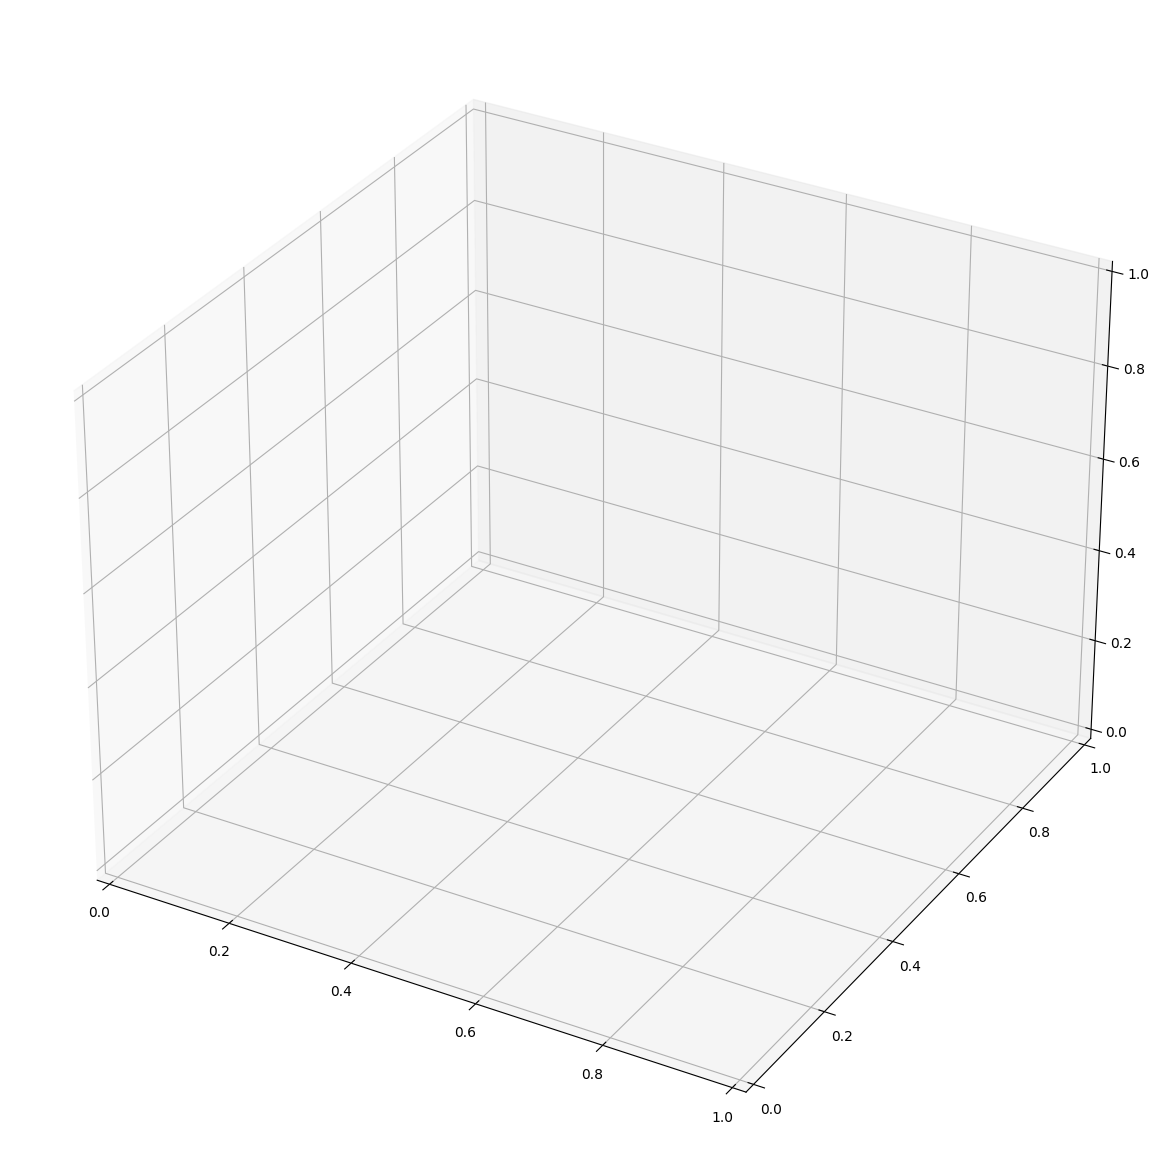

In [15]:
visualise_2D_gaussian_process(gaussian, (np.logspace(0.00, 1, 50) -1)/9, np.arange(10, 200, 1), np.arange(0.5, 1, 0.1))

In [ ]:
print(gec.best_params_)
knn_bayes = LGBMClassifier(**gec.best_params_)
score_bayes = np.mean(cross_val_score(knn_bayes, X, y, cv=5))
score_bayes

In [ ]:
knn_bayes = LGBMClassifier(**{'boosting': 'gbdt', 'lambda_l1': 0.46, 'num_leaves': 12})
score_bayes = np.mean(cross_val_score(knn_bayes, X, y, cv=5))
score_bayes